# Yelp Analytics

## Customer review sentiment analysis & restaurant classification

### Step 1. Load Dependencies and Datasets

In [336]:
## Action: 
## Loading dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import pos_tag, pos_tag_sents
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

In [137]:
## Action: 
## Loading datasets

path = "./yelp-dataset/"
business = pd.read_csv(path+"yelp_business.csv")
checkin = pd.read_csv(path+"yelp_checkin.csv")
review = pd.read_csv(path+"yelp_review.csv")
tip = pd.read_csv(path+"yelp_tip.csv")

In [138]:
business.head(3)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...


In [139]:
checkin.head(3)

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1


In [140]:
review.head(3)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0


In [141]:
tip.head(3)

,text,date,likes,business_id,user_id
0,Great breakfast large portions and friendly wa...,2015-08-12,0,jH19V2I9fIslnNhDzPmdkA,ZcLKXikTHYOnYt5VYRO5sg
1,Nice place. Great staff. A fixture in the tow...,2014-06-20,0,dAa0hB2yrnHzVmsCkN4YvQ,oaYhjqBbh18ZhU0bpyzSuw
2,Happy hour 5-7 Monday - Friday,2016-10-12,0,dAa0hB2yrnHzVmsCkN4YvQ,ulQ8Nyj7jCUR8M83SUMoRQ


### Step 2. Redundancy

In [142]:
## Action: 
## Create copies of datasets for redundancy

business_copy = business
checkin_copy = checkin
review_copy = review
tip_copy = tip

### Step 3. Data Exploration and Quality Assessment

###### 3a. Business

In [143]:
## Action:
## Check shape of dataframe (#rows, #columns)
business.shape

(174567, 13)

In [144]:
## Action:
## Check distinct count of businesses 
business.business_id.nunique()

174567

In [145]:
## Action:
## Check for missing values
business.isnull().sum()

business_id          0
name                 0
neighborhood    106552
address              0
city                 1
state                1
postal_code        623
latitude             1
longitude            1
stars                0
review_count         0
is_open              0
categories           0
dtype: int64

In [146]:
## Observation:
## A very large number of businesses with no duplication in the dataset
## Very large number of missing values in neighbourhood and postal_code. 
## It would be wise to remove these columns altogether. Location of restaurants is a significant attribute 
## and can be accounted for by latitude, longitude, and city
## Other columns having one missing value each are city, state, latitude, and longitude. 

###### 3b. Checkin

In [147]:
## Action:
## Check shape of dataframe (#rows, #columns)
checkin.shape

(3911218, 4)

In [148]:
## Action:
## Check distinct count of businesses 
checkin.business_id.nunique()

146350

In [149]:
## Action:
## Check for missing values
checkin.isnull().sum()

business_id    0
weekday        0
hour           0
checkins       0
dtype: int64

In [150]:
## Observation:
## A very large number of checkins with duplication of businesses in the dataset as expected.
## This resonates with my intuition that each business may have zero or multiple rows with individual checkin data 
## And there is no checkin_id or any other single column primary key
## Moreover, the count of businesses here (146350) is less than the total count of businesses (174567)
## which means that not all businesses have checkins
## Best part - no missing values in this dataset!

###### 3c. Review

In [151]:
## Action:
## Check shape of dataframe (#rows, #columns)
review.shape

(5261668, 9)

In [152]:
## Action:
## Check distinct count of reviews 
review.review_id.nunique()

5261668

In [153]:
## Action:
## Check distinct count of businesses 
review.business_id.nunique()

174567

In [154]:
## Action:
## Check for missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [155]:
## Observation:
## Extremely large number of reviews with duplication of businesses in the dataset as expected.
## This is a heavy dataset given that it has text reviews in each record
## Each business may have zero or multiple rows with individual review data 
## review_id is the primary key and business_id is the foreign key (one - many mapping)
## Total count of businesses here matches the actual total count (174567), so all businesses have at leats one review
## No missing values in this dataset either!

###### 3d. Tip

In [156]:
## Action:
## Check shape of dataframe (#rows, #columns)
tip.shape

(1098324, 5)

In [157]:
## Action:
## Check distinct count of businesses 
tip.business_id.nunique()

112365

In [158]:
## Action:
## Check for missing values
tip.isnull().sum()

text           2
date           0
likes          0
business_id    0
user_id        0
dtype: int64

In [159]:
## Observation:
## A very large number of tip data with duplication of businesses in the dataset as expected.
## Each business may have zero or multiple rows with individual tip data 
## And there is no tip_id or any other single column primary key
## Count of businesses here (112365) is way less than the total count of businesses (174567)
## which means that not all businesses have tip data (surprising as this should be available for all but maybe 
## not all restaurants have digital payments or records)
## Two missing values in this dataset for text and date columns each

### Step 4. Data Preparation

In [160]:
## Sidenote:
## Ideally, data cleaning and handling missing data precedes this step. However, the goal of this project is to
## perform a deep analysis on 99 restaurants (extremely small dataset as compared to the current size). 
## Therefore, reducing and creating and aggregated dataset first is the approach I'm going forward with 
## in order to manage both computing resource and time wisely

###### 4a. Downsize business dataframe

In [161]:
## Action:
## 1. Drop businesses which are not open (is_open == 0)
## 2. Drop businesses which are not in restaurant business (categories do not contain the keyword "food")
## 3. Drop businesses which have any missing values (remember there were 5 columns with missing values)
## 4. Create a random stratified sample of restaurants with equal weightage to 'stars' column (distinct count = 9)
## 5. Drop unnecessary columns (neighborhood, address, postal_code, is_open, categories) and reindex

def downsize_business(business):
    business.drop(business[business.is_open == 0].index, inplace = True)
    business.drop(business[~business['categories'].str.lower().str.contains('food')].index, inplace = True)
    business.dropna(axis=0, how='any', inplace = True)
    business1 = business.groupby('stars').apply(lambda x: x.sample(n=20))
    business1.drop(business1.columns[[2, 3, 6, 11, 12]], axis=1, inplace=True)
    business1 = business1.reset_index(drop=True)
    return business1

business1 = downsize_business(business)
business1.head()

,business_id,name,city,state,latitude,longitude,stars,review_count
0,4Jv9IJsVgwovMqv8YQJF1g,"""Cc's Creations""",Woodbridge,ON,43.784442,-79.594259,1.0,3
1,K-tl3k56Px2G6KRsKNyUUA,"""Subway""",Cleveland,OH,41.438300,-81.699207,1.0,4
2,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3
3,4FdXVA-WxWwc5rmjRPJVnQ,"""McDonald's""",Madison,WI,43.128766,-89.308580,1.0,4
4,e1UF53wfi3HKNmPHzc3OLg,"""Zaxby's Chicken Fingers & Buffalo Wings""",Charlotte,NC,35.163464,-80.970793,1.0,17


###### 4b. Downsize checkin dataframe

In [162]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe checkin1 having business ids in temp
## 3. Create a new dataframe checkin2 with aggregation (Business Id - Total count of checkins)

def downsize_checkin(checkin, business1):
    temp = business1['business_id'].tolist()
    checkin1 = checkin[checkin['business_id'].isin(temp)]
    checkin2 = checkin1.groupby('business_id').sum().reset_index()
    return checkin2

checkin2 = downsize_checkin(checkin, business1)
checkin2.head()

,business_id,checkins
0,-syU1HD-Iw_GEH8P5l03_A,3
1,06MlxbtB4ZYeg_ri02RIAQ,451
2,0R-6OcfG57Kg_uDro3ImPA,60
3,0RrHQNdsMK3jPlK4f9_wWA,32
4,0SYfS38_-7Mt20x9jNph_Q,18


In [163]:
## Naive check to see if any row didn't get aggregated. This should return 0
len(checkin2[checkin2['checkins'] < 1]) 

0

###### 4c. Join business and checkin dataframes

In [164]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe checkin1 having business ids in temp
## 3. Create a new dataframe checkin2 with aggregation (Business Id - Total count of checkins)

def merge_business_checkin(checkin2, business1):
    business_checkin = pd.merge(business1, checkin2, on='business_id', how='left')
    business_checkin.fillna(0)
    return business_checkin

business_checkin = merge_business_checkin(checkin2, business1)
business_checkin.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,checkins
0,4Jv9IJsVgwovMqv8YQJF1g,"""Cc's Creations""",Woodbridge,ON,43.784442,-79.594259,1.0,3,NaN
1,K-tl3k56Px2G6KRsKNyUUA,"""Subway""",Cleveland,OH,41.438300,-81.699207,1.0,4,4.0
2,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3,4.0
3,4FdXVA-WxWwc5rmjRPJVnQ,"""McDonald's""",Madison,WI,43.128766,-89.308580,1.0,4,25.0
4,e1UF53wfi3HKNmPHzc3OLg,"""Zaxby's Chicken Fingers & Buffalo Wings""",Charlotte,NC,35.163464,-80.970793,1.0,17,36.0


###### 4d. Downsize review dataframe

In [165]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe review1 having business ids in temp and keep only relevant columns
## 3. Create a new dataframe review2 with index resetting (for future operations on this dataset)

def downsize_review(review, business1):
    temp = business1['business_id'].tolist()
    review1 = review[review['business_id'].isin(temp)]
    review1 = review1[['business_id', 'stars', 'text']]
    review2 = review1.reset_index(drop=True)
    return review2

review2 = downsize_review(review, business1)
review2.head()

,business_id,stars,text
0,ACFtxLv8pGrrxMm6EgjreA,4,Love coming here. Yes the place always needs t...
1,5N8R7ALESZ30EoAzVJtabw,5,Went in on a whim and was not disappointed. I ...
2,wSojc-y-d7MWiGWdy8deCg,2,Was really looking forward to some good briske...
3,OMRYQihVjqqzjoNoQgyhgQ,2,"I'm so disappointed, this was the place to go ..."
4,JpgVl3d20CMRNjf1DVnzGA,3,I've been to 4 different Brazilian churrascari...


### 4e. Sentiment Analysis of customer reviews

In [166]:
## Action:

## 1. Clean the text data in review dataset
## 2. Tokenize all text to sentences and then words
## 3. Tag all the words with position tags
## 4. Convert all tags to wrodnet tags
## 5. Lemmatize the words and create synsets
## 6. Compute sentiment score (positive score - negative score)
## 7/ Return a sentiment polarity score: 1 = positive, 0 = negative

#nltk.download('punkt')
 
lemmatizer = WordNetLemmatizer()
  
def convert_tag(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
def clean_text(text):
    text = text.replace("<br />", " ")
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    #text = text.decode("utf-8")
    return text
 
def compute_swn_polarity_score(text):
    sentiment_score = 0.0
    num_tokens = 0
    text = clean_text(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tagged_sentence = pos_tag(word_tokenize(sentence))
        for word, tag in tagged_sentence:
            wn_tag = convert_tag(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment_score += swn_synset.pos_score() - swn_synset.neg_score()
            num_tokens += 1
    # sum greater than 0 => positive sentiment
    if sentiment_score >= 0:
        return 1
    # All other scenarios => negative sentiment
    else:
        return 0

In [167]:
## Action:
## Create a new column 'polarity' with sentiment polarity as 1 (positive) or 0 (negative)
review2['polarity'] = review2['text'].apply(compute_swn_polarity_score)
review2.head()

,business_id,stars,text,polarity
0,ACFtxLv8pGrrxMm6EgjreA,4,Love coming here. Yes the place always needs t...,1
1,5N8R7ALESZ30EoAzVJtabw,5,Went in on a whim and was not disappointed. I ...,1
2,wSojc-y-d7MWiGWdy8deCg,2,Was really looking forward to some good briske...,1
3,OMRYQihVjqqzjoNoQgyhgQ,2,"I'm so disappointed, this was the place to go ...",0
4,JpgVl3d20CMRNjf1DVnzGA,3,I've been to 4 different Brazilian churrascari...,0


In [168]:
## Now we will calculate the net positive sentiment score for each business as follows:
## net_positive_sentiment_score = sum(polarity) / total_count_of_reviews
## sum(polarity) for each business can be aggregated and obtained from review2 dataframe
## total_count_of_reviews is already available in business_checkin dataframe (review_count) column

In [169]:
## Action:
## 1. Create a new dataframe review3 by averaging all columns to give 99 distinct rows of business ids 
## 2. Reset index
## 3. Round up the 'stars' and 'polarity' columns to 2 decimals
## 4. Rename 'polarity' column to 'net_positive_sentiment' and 'stars' to 'review_stars'

def transform_review(review2):
    review3 = review2.groupby('business_id').mean().reset_index()
    #review3['stars'].round(2)
    review3['stars'] = review3['stars'].apply(lambda x: round(x,2))
    review3['polarity'] = review3['polarity'].apply(lambda x: round(x,2))
    review3.rename(columns={'polarity':'net_positive_sentiment_score'}, inplace=True)
    review3.rename(columns={'stars':'review_stars'}, inplace=True)
    return review3
review3 = transform_review(review2)
review3.head()

,business_id,review_stars,net_positive_sentiment_score
0,-syU1HD-Iw_GEH8P5l03_A,4.80,1.00
1,06MlxbtB4ZYeg_ri02RIAQ,2.36,0.49
2,0R-6OcfG57Kg_uDro3ImPA,3.75,0.60
3,0RrHQNdsMK3jPlK4f9_wWA,2.30,0.30
4,0SYfS38_-7Mt20x9jNph_Q,4.60,1.00


In [171]:
## Action:
## 1. Join business_checkin and review3 dataframces
## 2. Fill any missing values with 0

def merge_business_checkin_review(review3, business_checkin):
    business_checkin_review = pd.merge(business_checkin, review3, on='business_id', how='inner')
    business_checkin_review.fillna(0)
    return business_checkin_review

business_checkin_review = merge_business_checkin_review(review3, business_checkin)
business_checkin_review.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,checkins,review_stars,net_positive_sentiment_score
0,4Jv9IJsVgwovMqv8YQJF1g,"""Cc's Creations""",Woodbridge,ON,43.784442,-79.594259,1.0,3,NaN,1.00,0.67
1,K-tl3k56Px2G6KRsKNyUUA,"""Subway""",Cleveland,OH,41.438300,-81.699207,1.0,4,4.0,1.25,0.75
2,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3,4.0,1.00,0.00
3,4FdXVA-WxWwc5rmjRPJVnQ,"""McDonald's""",Madison,WI,43.128766,-89.308580,1.0,4,25.0,1.25,0.00
4,e1UF53wfi3HKNmPHzc3OLg,"""Zaxby's Chicken Fingers & Buffalo Wings""",Charlotte,NC,35.163464,-80.970793,1.0,17,36.0,1.24,0.18


###### 4f. Downsize tip

In [172]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe review1 having business ids in temp and keep only relevant columns
## 3. Create a new dataframe review2 with index resetting (for future operations on this dataset)

def downsize_tip(tip, business1):
    temp = business1['business_id'].tolist()
    tip1 = tip[tip['business_id'].isin(temp)]
    tip1 = tip1[['business_id', 'text']]
    tip2 = tip1.reset_index(drop=True)
    return tip2

tip2 = downsize_tip(tip, business1)
tip2.head()

,business_id,text
0,M-uo9HTEJEx7cS0eCsQyUg,If you don't like the pot of tea you order the...
1,dWkPcRiiEW97RwGhFZ3H5A,"Has ready-to-eat gulab jamun, unlike Kohli's, ..."
2,egpDg61SdYbKWvCpPM7Nbg,The Kauai pie!!! Triple yum!
3,M-uo9HTEJEx7cS0eCsQyUg,Brunch
4,M-uo9HTEJEx7cS0eCsQyUg,First time high tea!!


### 4g. Sentiment Analysis of reviews at the time of giving tips

In [173]:
tip2['polarity'] = tip2['text'].apply(compute_swn_polarity_score)
tip2.head()

,business_id,text,polarity
0,M-uo9HTEJEx7cS0eCsQyUg,If you don't like the pot of tea you order the...,1
1,dWkPcRiiEW97RwGhFZ3H5A,"Has ready-to-eat gulab jamun, unlike Kohli's, ...",1
2,egpDg61SdYbKWvCpPM7Nbg,The Kauai pie!!! Triple yum!,1
3,M-uo9HTEJEx7cS0eCsQyUg,Brunch,1
4,M-uo9HTEJEx7cS0eCsQyUg,First time high tea!!,0


In [174]:
## Action:
## 1. Create a new dataframe tip3 by averaging all columns to give 99 distinct rows of business ids 
## 2. Reset index
## 3. Round up the 'polarity' columns to 2 decimals
## 4. Rename 'polarity' column to 'net_positive_sentiment'

def transform_tip(tip2):
    tip3 = tip2.groupby('business_id').mean().reset_index()
    tip3['polarity'] = tip3['polarity'].apply(lambda x: round(x,2))
    tip3.rename(columns={'polarity':'net_positive_sentiment_score'}, inplace=True)
    return tip3

tip3 = transform_tip(tip2)
tip3.head()

,business_id,net_positive_sentiment_score
0,06MlxbtB4ZYeg_ri02RIAQ,0.53
1,0R-6OcfG57Kg_uDro3ImPA,0.67
2,0RrHQNdsMK3jPlK4f9_wWA,0.00
3,1Hvm57g7zTpBR2hhFg8awQ,0.50
4,1NeLactWtnH2g8z1v4nrgA,0.67


In [191]:
## Action:
## 1. Join business_checkin_review and tip3 dataframes
## 2. Fill any missing values with 0

def merge_business_checkin_review_tip(tip3, business_checkin_review):
    business_checkin_review_tip = pd.merge(business_checkin_review, tip3, on='business_id', how='left')
    business_checkin_review_tip.rename(columns={'net_positive_sentiment_score_x':'net_positive_sentiment_score_review'}, inplace=True)
    business_checkin_review_tip.rename(columns={'net_positive_sentiment_score_y':'net_positive_sentiment_score_tip'}, inplace=True)
    return business_checkin_review_tip

business_checkin_review_tip = merge_business_checkin_review_tip(tip3, business_checkin_review)
business_checkin_review_tip.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,checkins,review_stars,net_positive_sentiment_score_review,net_positive_sentiment_score_tip
0,4Jv9IJsVgwovMqv8YQJF1g,"""Cc's Creations""",Woodbridge,ON,43.784442,-79.594259,1.0,3,NaN,1.00,0.67,NaN
1,K-tl3k56Px2G6KRsKNyUUA,"""Subway""",Cleveland,OH,41.438300,-81.699207,1.0,4,4.0,1.25,0.75,NaN
2,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3,4.0,1.00,0.00,0.0
3,4FdXVA-WxWwc5rmjRPJVnQ,"""McDonald's""",Madison,WI,43.128766,-89.308580,1.0,4,25.0,1.25,0.00,NaN
4,e1UF53wfi3HKNmPHzc3OLg,"""Zaxby's Chicken Fingers & Buffalo Wings""",Charlotte,NC,35.163464,-80.970793,1.0,17,36.0,1.24,0.18,1.0


In [194]:
data = business_checkin_review_tip
data = data.dropna()
len(data)

144

### Step 5. Exploratory Data Analysis

#### 5a. Correlation Heatmap

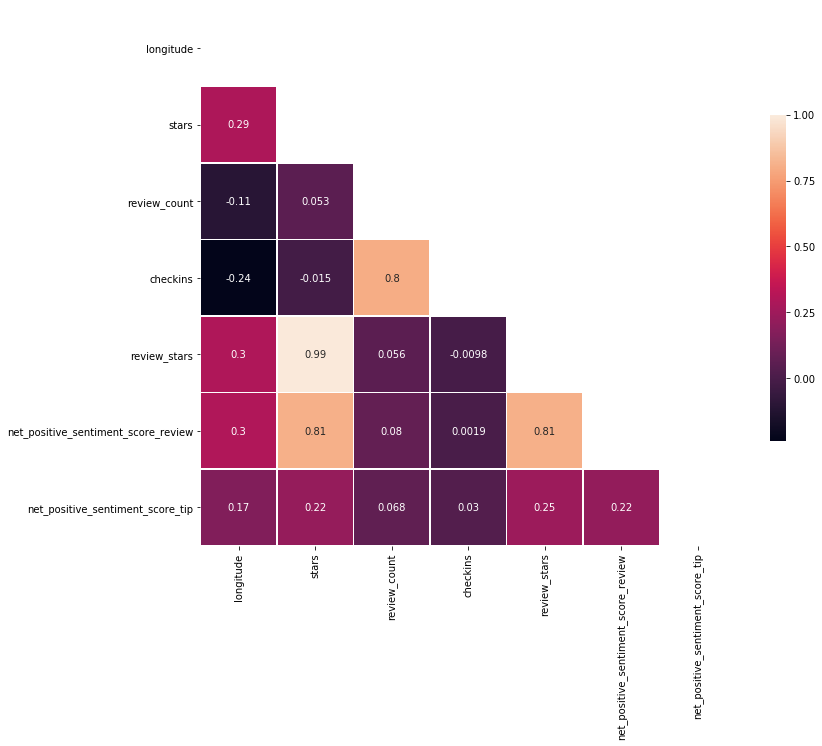

In [196]:
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
## Observation:
## stars has high correlation with review_stars and net_positive_sentiment_score_review
## review_count and checkins are also highly correlated. So we should use only one of these in the model
## review_stars and net_positive_sentiment_score_review also has a high correlation

## So to sum up, we need to eliminate review_stars
## Also, between review_count and checkins, I will eliminate review_count as it is already accounted for 
## in the computation of net_positive_sentiment_score_review

## Ultimately, I shall move ahead with following features
## 1. net_positive_sentiment_score_review
## 2. net_positive_sentiment_score_tip
## 3. checkins

In [ ]:
data.drop(data.columns[[7, 9]], axis=1, inplace=True)

In [198]:
data.head()

,business_id,name,city,state,latitude,longitude,stars,checkins,net_positive_sentiment_score_review,net_positive_sentiment_score_tip
2,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,4.0,0.00,0.0
4,e1UF53wfi3HKNmPHzc3OLg,"""Zaxby's Chicken Fingers & Buffalo Wings""",Charlotte,NC,35.163464,-80.970793,1.0,36.0,0.18,1.0
5,iYQPfLcPQXiYi-kycrm2rw,"""Sparkletts Water""",Las Vegas,NV,36.128999,-115.196301,1.0,2.0,0.16,1.0
7,RUbB6951mueG7dm6lIpkcg,"""McDonald's""",Mississauga,ON,43.636922,-79.718306,1.0,41.0,0.40,1.0
8,u7bjH0lJcE7Q4BFlKTPJcg,"""Swiss Chalet Rotisserie & Grill""",Toronto,ON,43.646449,-79.379615,1.0,10.0,0.00,1.0


In [ ]:
### Visualization for the set of restaurants we have

### Restaurant Category Creation

#### Awesome     ::     stars >= 3.5
#### Average        ::     stars 2.0 < x < 3.5
#### Not really      ::     stars <= 2.0

In [429]:
## Action:
## Categorize all restaurants

def categorize(data):
    if data['stars'] >= 3.5:
        return 'Awesome'
    elif data['stars'] <= 2.0:
        return 'Not Really'
    else:
        return 'Average'
    
data['restaurant_category'] = data.apply(categorize, axis=1)

data.tail()

,business_id,name,city,state,latitude,longitude,stars,checkins,net_positive_sentiment_score_review,net_positive_sentiment_score_tip,restaurant_category
173,6aOnrzf15RMqFNOQ-_ElIA,"""COCO Crafted Organic Chocolate""",Toronto,ON,43.657599,-79.487683,5.0,16.0,0.88,0.83,Awesome
174,wsgWLUX6ZVBEBQglZRVt2w,"""Linda's Superette""",Cleveland,OH,41.490816,-81.709332,5.0,271.0,0.50,0.57,Awesome
175,YDVfq0xvdxVlA2KQbJLv-A,"""Kostas Meat Market & Deli""",Scarborough,ON,43.760794,-79.302096,5.0,8.0,1.00,1.00,Awesome
176,eL4hY2W2PAuFqIhQDW-ndA,"""Rosevear Tea""",Edinburgh,EDH,55.937256,-3.207193,5.0,22.0,1.00,1.00,Awesome
177,3C0bnFhjkgYP9mWORKg6cA,"""Chili Man""",Charlotte,NC,35.226911,-80.843823,5.0,154.0,0.78,0.80,Awesome


#### 5b. Exploring effect of net_positive_sentiment_score_review on Restaurant_Category (Star Rating)

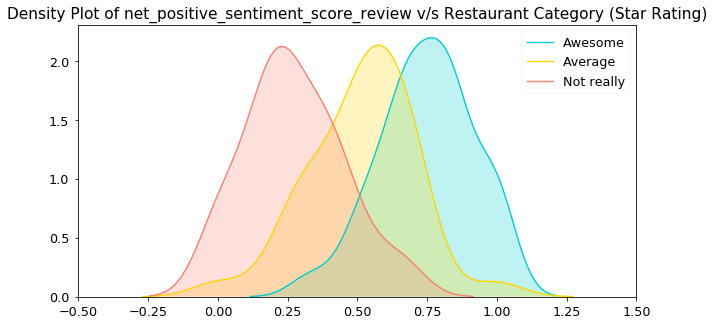

In [435]:
plt.figure(figsize=(10,5))
sns.set_context("paper", font_scale=1.6)
sns.kdeplot(data["net_positive_sentiment_score_review"][data.restaurant_category == "Awesome"], 
            color="darkturquoise", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_review"][data.restaurant_category == "Average"], 
            color="gold", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_review"][data.restaurant_category == "Not Really"], 
            color="salmon", shade=True)
plt.xlim(-0.5,1.5)
plt.legend(['Awesome', 'Average', 'Not really'])
plt.title('Density Plot of net_positive_sentiment_score_review v/s Restaurant Category (Star Rating)')
plt.show()

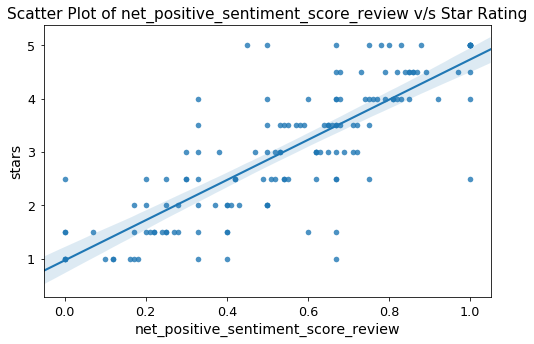

In [436]:
plt.figure(figsize=(8,5))
sns.set_context("paper", font_scale=1.6)
sns.regplot(x=data["net_positive_sentiment_score_review"], y=data["stars"])
plt.title('Scatter Plot of net_positive_sentiment_score_review v/s Star Rating')
plt.show()

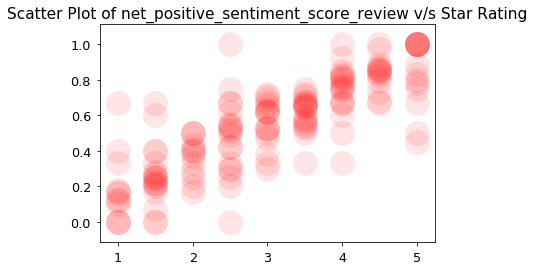

In [456]:
plt.title('Scatter Plot of net_positive_sentiment_score_review v/s Star Rating')
sns.set_context("paper", font_scale=1.6)
plt.scatter(data['stars'], data2['net_positive_sentiment_score_review'], s=600, c="red", alpha=0.1)

In [ ]:
## Observation:
## Star Rating (and therefore, restaurant_category) have a strong linear relationship with 
## net_positive_sentiment_score_review. This was intuitive but since I computed the score myself via sentiment analysis
## this is a strong evidence that the sentiment analysis was rightly done

#### 5b. Exploring effect of net_positive_sentiment_score_tip on Restaurant_Category (Star Rating)

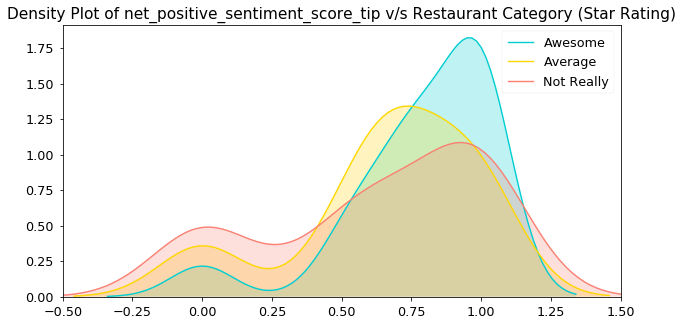

In [447]:
plt.figure(figsize=(10,5))
sns.set_context("paper", font_scale=1.6)
sns.kdeplot(data["net_positive_sentiment_score_tip"][data.restaurant_category == "Awesome"], 
            color="darkturquoise", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_tip"][data.restaurant_category == "Average"], 
            color="gold", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_tip"][data.restaurant_category == "Not Really"], 
            color="salmon", shade=True)
plt.xlim(-0.5,1.5)
plt.legend(['Awesome', 'Average', 'Not Really'])
plt.title('Density Plot of net_positive_sentiment_score_tip v/s Restaurant Category (Star Rating)')
plt.show()

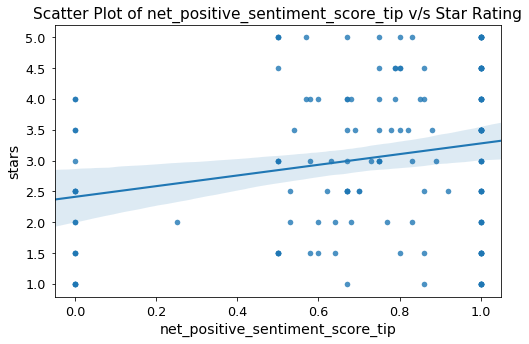

In [445]:
plt.figure(figsize=(8,5))
sns.set_context("paper", font_scale=1.6)

sns.regplot(x=data["net_positive_sentiment_score_tip"], y=data["stars"])
plt.title('Scatter Plot of net_positive_sentiment_score_tip v/s Star Rating')
plt.show()

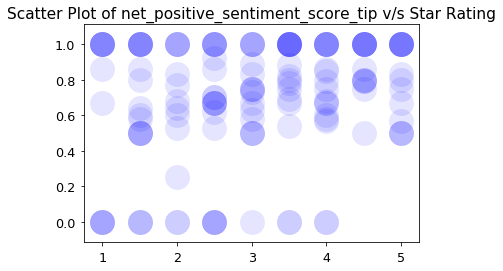

In [458]:
plt.title('Scatter Plot of net_positive_sentiment_score_tip v/s Star Rating')
sns.set_context("paper", font_scale=1.6)
plt.scatter(data['stars'], data2['net_positive_sentiment_score_tip'], s=600, c="blue", alpha=0.1)

In [ ]:
## Observation:
## Star Rating (and therefore, restaurant_category) do not have a great linear relationship with 
## net_positive_sentiment_score_tip. This is interesting and has two explanations. 
## One is that the sentiment analysis of tip reviews was not accurate enough
## Two which is more of a logical fact that a customer is more likely to give reviews while shelling out tips
## when he / she is impressed with the restaurant's service. 
## Therefore, it seems like this is a biased / unbalanced attribute!

#### 5c. Exploring effect of number of checkins on Restaurant_Category (Star Rating)

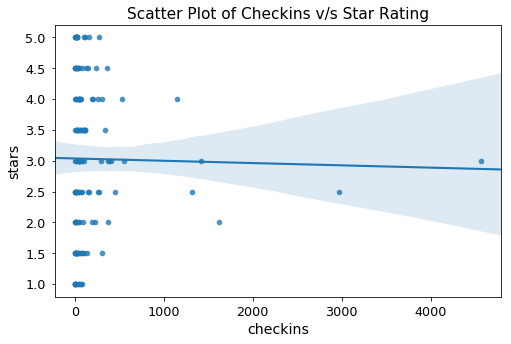

In [452]:
plt.figure(figsize=(8,5))
sns.set_context("paper", font_scale=1.6)
sns.regplot(x=data["checkins"], y=data["stars"])
plt.title('Scatter Plot of Checkins v/s Star Rating')
plt.show()

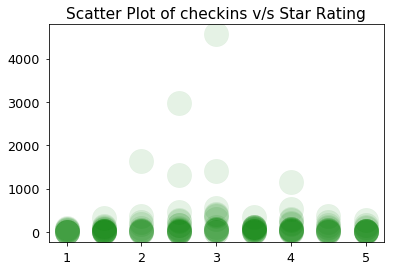

In [459]:
plt.title('Scatter Plot of checkins v/s Star Rating')
sns.set_context("paper", font_scale=1.6)
plt.scatter(data['stars'], data2['checkins'], s=600, c="green", alpha=0.1)

In [ ]:
## Observation:
## Star Rating (and therefore, restaurant_category) seem to have a weak relationship with 
## number of checkins . Moreover, some of the average rating restaurants have a high number of checkins
## compared to the average. Again this is interesting and has an explanation. 
## Most average rating restaurants give out discounts or deals upon mandatory checkins to boost customer footfalls!

#### 5d. Compare all three effects

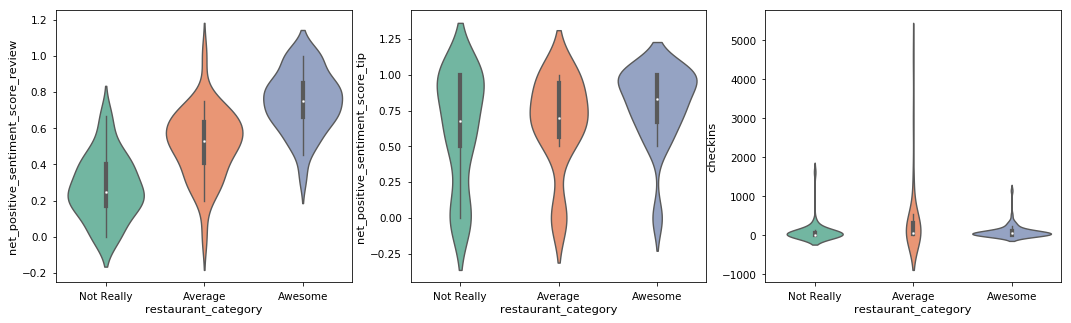

In [463]:
plt.figure(figsize=(18,5))
sns.set_context("paper", font_scale=1.3)
plt.subplot(1,3,1)
sns.violinplot(x='restaurant_category',y='net_positive_sentiment_score_review',data=data, shade = True, palette="Set2")
plt.subplot(1,3,2)
sns.violinplot(x='restaurant_category',y='net_positive_sentiment_score_tip',data=data, shade = True, palette="Set2")
plt.subplot(1,3,3)
sns.violinplot(x='restaurant_category',y='checkins',data=data, shade = True, palette="Set2")
#plt.title('Violin Plot of No of Checkins v/s Restaurant Category (Star Rating)')

### Step 6. Machine Learning

###### 6a. Creating test and training datasets

In [261]:
final_data = data[['business_id', 'restaurant_category', 'checkins', 'net_positive_sentiment_score_review', 
                  'net_positive_sentiment_score_tip']]

In [262]:
final_data.head()

,business_id,restaurant_category,checkins,net_positive_sentiment_score_review,net_positive_sentiment_score_tip
2,QcTpYpgEYSZ6vPGgz3LiDQ,Not Really,4.0,0.00,0.0
4,e1UF53wfi3HKNmPHzc3OLg,Not Really,36.0,0.18,1.0
5,iYQPfLcPQXiYi-kycrm2rw,Not Really,2.0,0.16,1.0
7,RUbB6951mueG7dm6lIpkcg,Not Really,41.0,0.40,1.0
8,u7bjH0lJcE7Q4BFlKTPJcg,Not Really,10.0,0.00,1.0


In [339]:
X = final_data[['checkins', 'net_positive_sentiment_score_review', 'net_positive_sentiment_score_tip']]
y = final_data[['restaurant_category']].values.ravel()

In [345]:
## Action:
## Scaling the features

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [412]:
classifiers = []
accuracies = []

#### 6b. Support Vector Machine

In [413]:
clf = svm.SVC(kernel = 'rbf', C = 100) 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('svm.SVC')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.7273


#### 6c. Decision Tree

In [414]:
clf = tree.DecisionTreeClassifier(max_depth = 5) 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('DecisionTreeClassifier')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.6818


#### 6d. Logistic Regression

In [415]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('LogisticRegression')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.6591


#### 6e. Gaussian Naive Bayes

In [416]:
clf = GaussianNB() 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('GaussianNB')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.6818


#### 6f. K Neighbours 

In [417]:
clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(round(accuracy, 4))

0.6818


([<matplotlib.axis.XTick at 0x44940ecc0>,
 <a list of 10 Text xticklabel objects>)

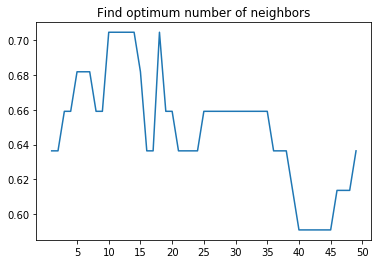

In [418]:
l=list(range(1,50))
a=pd.Series()
x=[5,10,15,20,25,30,35,40,45,50]
for i in l:
    clf = KNeighborsClassifier(n_neighbors=i) 
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    a = a.append(pd.Series(accuracy_score(pred, y_test)))
plt.title('Find optimum number of neighbors')
plt.plot(l, a)
plt.xticks(x)

In [419]:
clf = KNeighborsClassifier(n_neighbors = 12)
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('KNeighborsClassifier')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.7045


### Step 7. Model Comparison

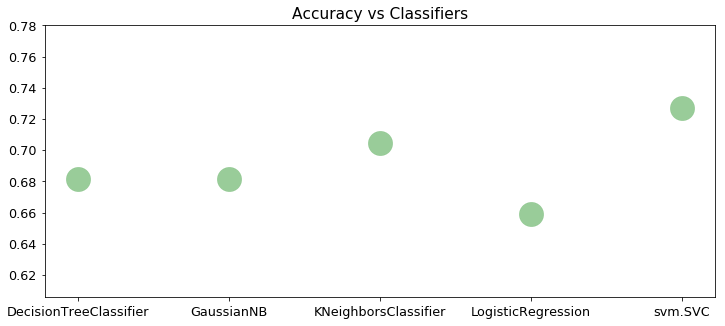

In [464]:
plt.figure(figsize=(12,5))
sns.set_context("paper", font_scale=1.6)
plt.scatter(classifiers, accuracies, s=600, c="green", alpha=0.4)
# plt.figure(figsize=(8,5))
# sns.regplot(x=classifiers, y=accuracies)
plt.title('Accuracy vs Classifiers')
plt.show()

In [ ]:
## Deep Learning

In [ ]:
# TRAIN_URL = "http://download.tensorflow.org/data/iris_training.csv"
# TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"

# CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth',
#                     'PetalLength', 'PetalWidth', 'Species']
# SPECIES = ['Setosa', 'Versicolor', 'Virginica']

# def maybe_download():
#     train_path = tf.keras.utils.get_file(TRAIN_URL.split('/')[-1], TRAIN_URL)
#     test_path = tf.keras.utils.get_file(TEST_URL.split('/')[-1], TEST_URL)

#     return train_path, test_path

# def load_data(y_name='Species'):
#     """Returns the iris dataset as (train_x, train_y), (test_x, test_y)."""
#     train_path, test_path = maybe_download()

#     train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
#     train_x, train_y = train, train.pop(y_name)

#     test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
#     test_x, test_y = test, test.pop(y_name)

#     return (train_x, train_y), (test_x, test_y)


def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    #dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = final_data

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset


def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset


# The remainder of this file contains a simple example of a csv parser,
#     implemented using a the `Dataset` class.

# `tf.parse_csv` sets the types of the outputs to match the examples given in
#     the `record_defaults` argument.
CSV_TYPES = [[0.0], [0.0], [0.0], [0.0], [0]]

def _parse_line(line):
    # Decode the line into its fields
    fields = tf.decode_csv(line, record_defaults=CSV_TYPES)

    # Pack the result into a dictionary
    features = dict(zip(CSV_COLUMN_NAMES, fields))

    # Separate the label from the features
    label = features.pop('Species')

    return features, label


def csv_input_fn(csv_path, batch_size):
    # Create a dataset containing the text lines.
    dataset = tf.data.TextLineDataset(csv_path).skip(1)

    # Parse each line.
    dataset = dataset.map(_parse_line)

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

## K-Means Clustering Analysis

In [492]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
#km = KMeans()
y_km = km.fit_predict(X)

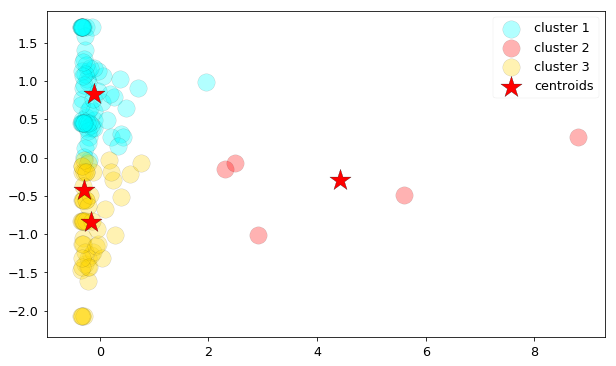

In [540]:
plt.figure(figsize=(10,6))
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=300, c='cyan', marker='o', alpha = 0.3, edgecolor='black', label='cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=300, c='red', marker='o', alpha = 0.3, edgecolor='black', label='cluster 2')
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=300, c='gold', marker='o', alpha = 0.3, edgecolor='black', label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=500, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend(scatterpoints=1)
plt.show()

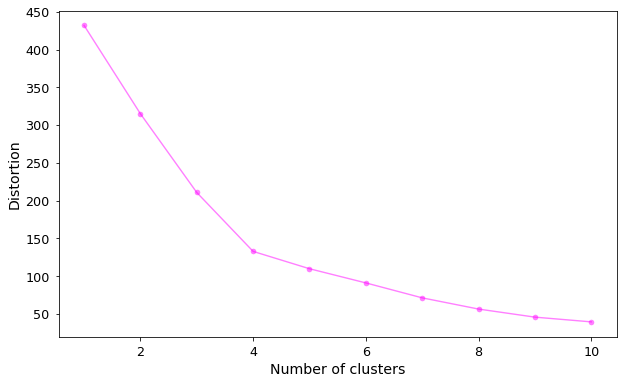

In [547]:
plt.figure(figsize=(10,6))
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o', alpha = 0.5, color = "fuchsia")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [494]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
#km = KMeans()
y_km = km.fit_predict(X)

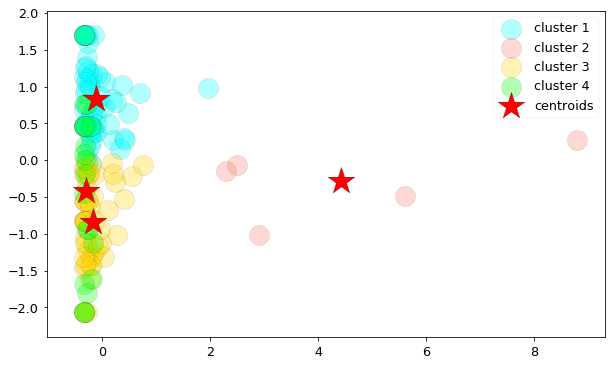

In [539]:
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.6)
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=400, c='cyan', marker='o', alpha = 0.3, edgecolor='black', label='cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=400, c='salmon', marker='o', alpha = 0.3, edgecolor='black', label='cluster 2')
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=400, c='gold', marker='o', alpha = 0.3, edgecolor='black', label='cluster 3')
plt.scatter(X[y_km == 3, 0], X[y_km == 3, 1], s=400, c='lime', marker='o', alpha = 0.3, edgecolor='black', label='cluster 4')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=800, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend(scatterpoints=1)
#plt.grid()
plt.show()

In [ ]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()

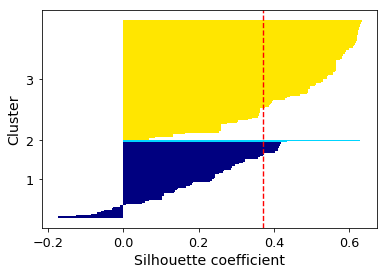

In [548]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0, edgecolor = 'none', color = color)
    yticks.append((y_ax_lower + y_ax_upper) /2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()
